In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import regularizers
from keras.layers import Dense, LSTM, Activation, Input, add
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import xlrd
import datetime
import os
import tensorflow as tf
from keras.utils import plot_model

import copy

from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def parser(x):
    return pd.datetime.strptime('190'+x,'%Y-%m')

def train_test_split(df,rate = 0.5):
    train,test = df[:int(df.shape[0]*rate)+1],df[int(df.shape[0]*rate)+1:]
    return (train,test)

def timeseries_to_supervised(data,lag = 1):
    df = pd.DataFrame(data)
   #print(df.shape)
    columns = [df.shift(i) for i in range(1,lag+1)]
    #print(columns)
    columns.append(df)
    df = pd.concat(columns,axis = 1)
    df.fillna(0,inplace = True)
    #print(df.shape)
    return df

def difference(df,interval = 1):
    diff = list()
    for i in range(interval,df.shape[0]):
        diff.append(df[i] - df[i-interval])
    return pd.Series(diff)

def inverse_difference(history,yhat,interval = 1):
    return yhat + history[-interval]

def train_test_scale(train,test):
    scaler = MinMaxScaler(feature_range = (-1,1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0],train.shape[1])
    test = test.reshape(test.shape[0],test.shape[1])
    scaled_train = scaler.transform(train)
    scaled_test = scaler.transform(test)
    
    return scaled_train,scaled_test,scaler

def invert_scale(scaler,X,value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1,len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0,-1]
    
def fit_lstm_1(train,batch_size,epochs,neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0],X.shape[1],1)
    inputs = Input(batch_shape = (batch_size,X.shape[1],X.shape[2]))
    lstm_layer_1 = LSTM(neurons,batch_input_shape = (batch_size,X.shape[1],X.shape[2]),
                        activation = 'relu',kernel_regularizer = regularizers.l2(0.1),
                        recurrent_regularizer = regularizers.l2(0.03),
                        bias_regularizer = regularizers.l2(0.01),
                        stateful = True,return_sequences = False)(inputs)
    dense_1 = Dense(neurons,activation = 'relu',name = 'dense_1')(lstm_layer_1)
    added_0 = add([lstm_layer_1,dense_1])
    dense_2 = Dense(neurons,activation = 'relu',name = 'dense_2')(dense_1)
    added_1 = add([dense_2,added_0])
    dense_3 = Dense(neurons,activation = 'relu',name = 'dense_3')(added_1)
    added_2 = add([dense_3,added_1])
    dense_4 = Dense(neurons,activation = 'relu',name = 'dense_4')(added_2)
    added_3 = add([dense_4,added_2])
    dense_5 = Dense(neurons,activation = 'relu',name = 'dense_5')(added_3)
    added_4 = add([dense_5,added_3])
    dense_6 = Dense(neurons,activation = 'relu',name = 'dense_6')(added_4)
    added_5 = add([dense_6,added_4])
#     dense_7 = Dense(neurons,activation = 'relu',name = 'dense_7')(added_5)
#     added_6 = add([dense_7,added_5])
#     dense_8 = Dense(neurons,activation = 'relu',name = 'dense_8')(added_6)
#     added_7 = add([dense_8,added_6])
#     dense_9 = Dense(neurons,activation = 'tanh',name = 'dense_9')(added_7)
#     added_8 = add([dense_9,added_7])
#     dense_10 = Dense(neurons,activation = 'tanh',name = 'dense_10')(added_8)
#     added_9 = add([dense_10,added_8])
#     dense_11 = Dense(neurons,activation = 'relu',name = 'dense_11')(added_9)
#     added_10 = add([dense_11,added_9])
#     dense_12 = Dense(neurons,activation = 'relu',name = 'dense_12')(added_10)
#     added_11 = add([dense_12,added_10])
#     dense_13 = Dense(neurons,activation = 'relu',name = 'dense_13')(added_11)
#     added_12 = add([dense_13,added_11])
#     dense_14 = Dense(neurons,activation = 'relu',name = 'dense_14')(added_12)
#     added_13 = add([dense_14,added_12])
#     dense_15 = Dense(neurons,activation = 'relu',name = 'dense_15')(added_13)
#     added_14 = add([dense_15,added_13])
#     dense_16 = Dense(neurons,activation = 'relu',name = 'dense_16')(added_14)
#     added_15 = add([dense_16,added_14])

    output = Dense(1,name = 'output')(added_5)
    model = Model(inputs = inputs,outputs = output)

    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    
    try:
        model.load_weights('model_1_weight.h5')
    except:
        pass
    
    historys = list()
    for i in range(epochs):
        history = model.fit(X,y,epochs = 1,batch_size = batch_size,verbose = 0,shuffle = False)
        model.reset_states()
        historys.append(history.history['loss'])
        print('Epoch:'+str(i+1)+' Loss:'+str(history.history['loss']))
        
    model.save_weights('model_1_weight.h5')
    
    return model,historys

def plot_loss(historys):
    plt.plot(range(1,len(historys)+1),historys)
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def mean_absolute_percentage_error(y_true,y_pred):
    return np.sum(np.divide(np.absolute(np.subtract(y_true,y_pred)),y_true))/len(y_true)

def mean_absolute_error(y_true,y_pred):
    return np.sum(np.absolute(np.subtract(y_true,y_pred)))/len(y_true)

def get_session(gpu_fraction=0.3):

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [38]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
data = xlrd.open_workbook('Data.xls')



                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 8783
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -51241.627
Method:                       css-mle   S.D. of innovations             82.701
Date:                Mon, 03 Dec 2018   AIC                         102497.254
Time:                        21:18:53   BIC                         102546.818
Sample:                             1   HQIC                        102514.140
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0505      1.223     -0.041      0.967      -2.447       2.346
ar.L1.D.y     -0.1015      0.011     -9.546      0.000      -0.122      -0.081
ar.L2.D.y      0.0452      0.011      4.261      0.0

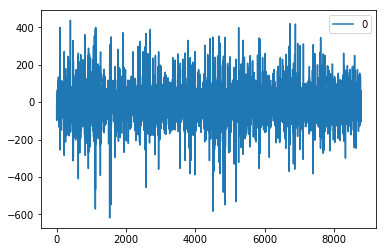

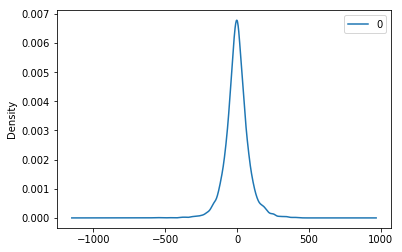

                 0
count  8783.000000
mean      0.007018
std      82.706338
min    -619.621785
25%     -42.118216
50%      -0.871862
75%      40.578264
max     438.321592


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.08922199479503581


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.06716850474574228


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.06869996367736063
0.06508504198869967


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.07073219463516828
0.06944883230265804
0.07393074465795658


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.05759493076523098


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.06212144290122792


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.1703280044143916


C:\Users\user\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.08255279994923558


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.0737553804026038


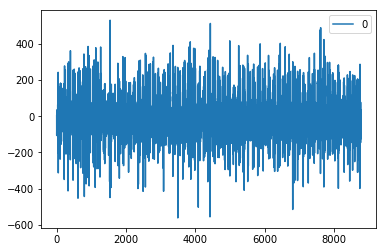

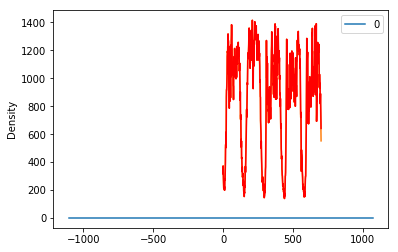

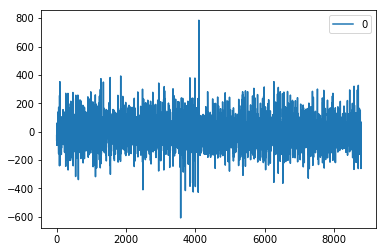

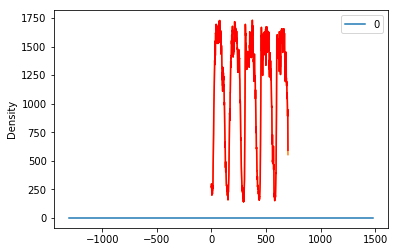

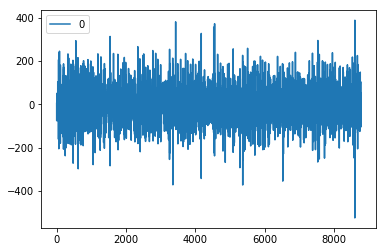

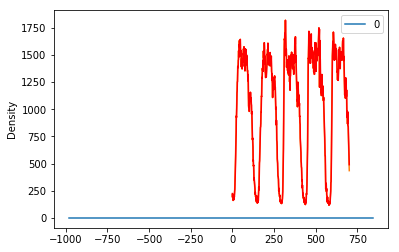

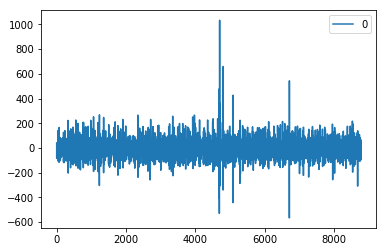

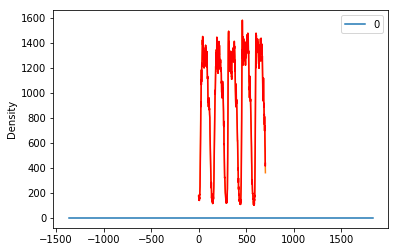

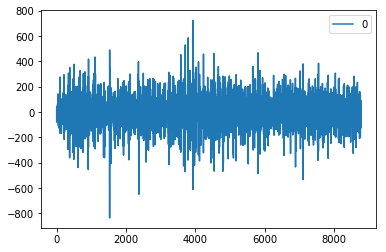

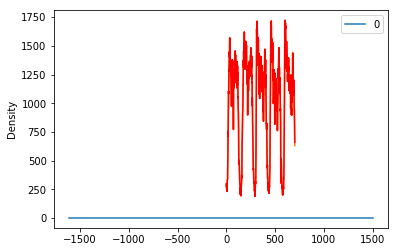

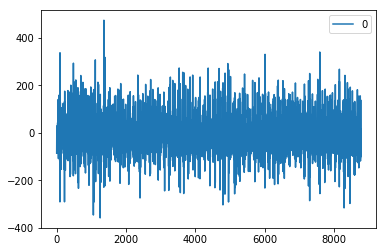

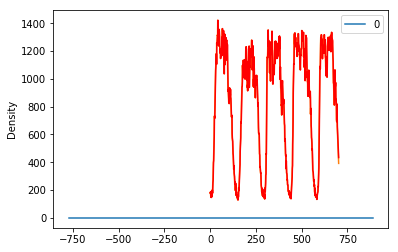

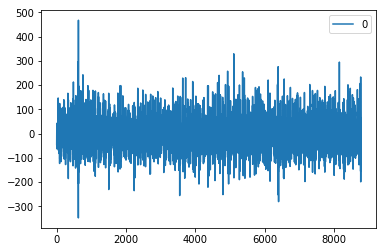

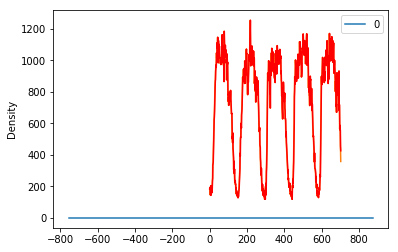

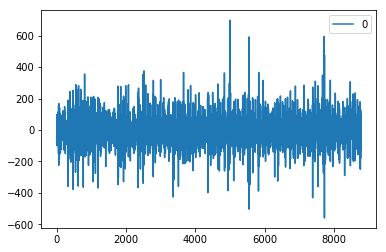

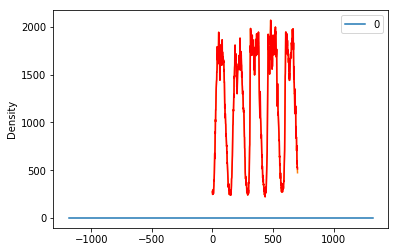

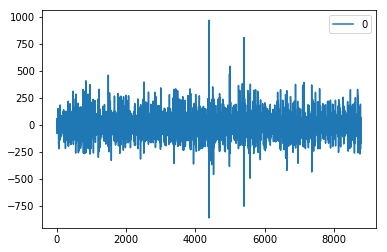

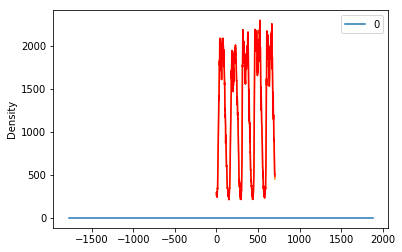

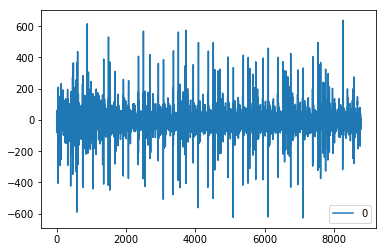

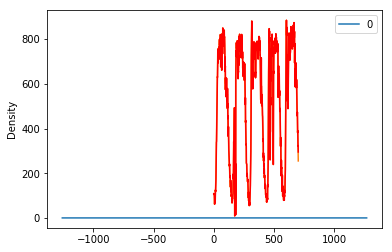

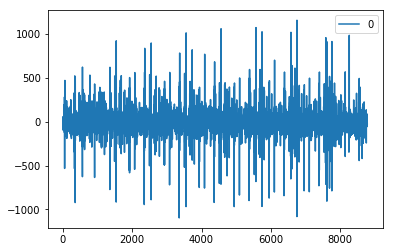

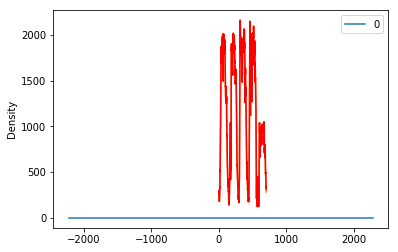

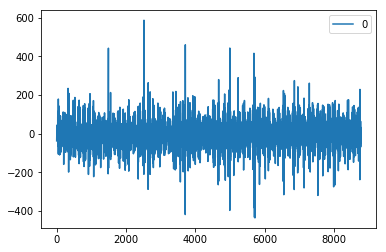

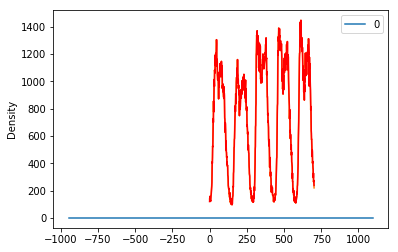

In [47]:
for i in range(2,14):

    table = data.sheets()[i]
    raw_flow = table.col_values(0)
    flow = np.array([i for i in raw_flow[1:]])

    model = ARIMA(flow, order=(5,1,0))
    model_fit = model.fit(disp=0)
#     print(model_fit.summary())
    # plot residual errors
    residuals = DataFrame(model_fit.resid)
    residuals.plot()
#     plt.show()
    residuals.plot(kind='kde')
#     plt.show()
#     print(residuals.describe())

    t1 = datetime.now()
    size = int(len(flow) * 0.92)
    train, test = flow[0:size], flow[size:len(flow)]
    scaled_train = train
    # [(x-train.min())/(train.max()-train.min()) for x in train]
    scaled_test = test
    # [(x-test.min())/(test.max()-test.min()) for x in test]
    history = [x for x in scaled_train]
    predictions = list()
#     print(len(test))
    for t in range(len(scaled_test)):
        model = ARIMA(history, order=(0,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = scaled_test[t]
        history.append(obs)
#         print('Sample: %d' %t)
#         print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(scaled_test, predictions)
#     print('Test MSE: %.3f' % error)
    # plot
    plt.plot(scaled_test)
    plt.plot(predictions, color='red')
#     plt.show()

    t2 = datetime.now()
#     print(t2-t1)
    scaled_pre = np.multiply(predictions,(test.max() - test.min())) + test.min()
    pre = [x[0] for x in predictions]
    print(mean_absolute_percentage_error(pre,test))

In [41]:
0.003*(test.max()-test.min())+test.min()

163.212

0.06516388277325262

In [27]:
len(pre)

703